In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statannot import add_stat_annotation
from adjustText import adjust_text

anot = pd.read_csv('aneuploidy_data_NEW.csv',index_col=0)

anot_CCLE = anot.copy()
anot_CCLE.index = anot_CCLE.loc[:,'CCLE_ID']

from cds import plotting

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
my_order = order=['Diploid','Aneuploid']

from taigapy import TaigaClient
tc = TaigaClient()

gene_effect_rnai_achilles = tc.get(name='demeter2-achilles-5386', version=13, file='gene_effect')
gene_effect_rnai_drive = tc.get(name='demeter2-drive-0591', version=12, file='gene_effect')
gene_effect_crispr_achilles = tc.get(name='avana-public-tentative-19q4-c2df', version=4, file='gene_effect')




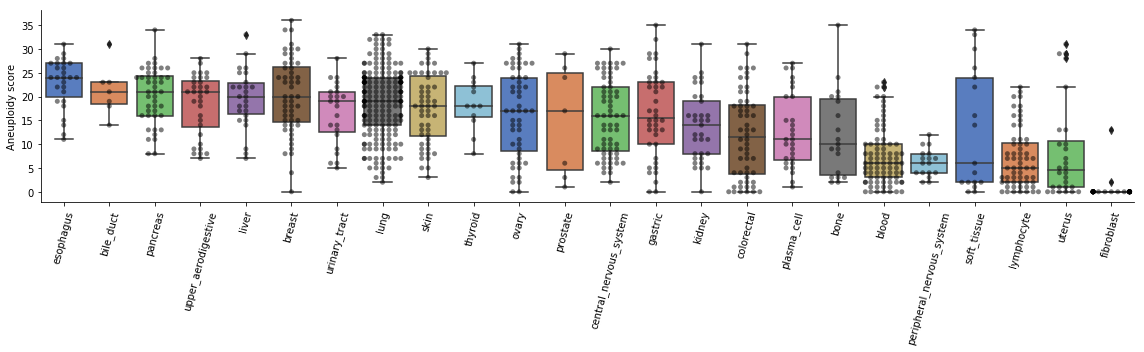

In [7]:
##########################################################################################
######################################### figex 2a #######################################
##########################################################################################


plt.subplots(figsize=(16,5))

sample_info = tc.get(name='internal-19q4-fb11', version=29, file='sample_info')

sample_info.index = sample_info.loc[:,'CCLE_Name'] 

sample_info = sample_info[~sample_info.index.duplicated(keep='first')]



num_arm = pd.DataFrame(anot_CCLE.loc[:,'num_arm_events'])
num_arm['lineage'] = sample_info.loc[num_arm.index,'lineage']




num_arm_ = num_arm.copy()

ax = sns.boxplot(x="lineage", y="num_arm_events",
                     data=num_arm_ ,palette="muted",order = num_arm_.groupby('lineage').median().sort_values('num_arm_events',ascending=False).index)
sns.swarmplot(x="lineage", y="num_arm_events",
                    data=num_arm_,color='black',alpha=.5,order = num_arm_.groupby('lineage').median().sort_values('num_arm_events',ascending=False).index)#palette="muted")

plt.xticks(rotation=75) 
plt.ylabel('Aneuploidy score')
plt.xlabel('')
plotting.simpleaxis(ax)
plt.tight_layout()
#plt.savefig('supp1/lineages_1.pdf')

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. damaging: t-test independent samples, P_val=6.059e-15 stat=-8.034e+00
WT v.s. hotspot: t-test independent samples, P_val=1.047e-22 stat=-1.014e+01


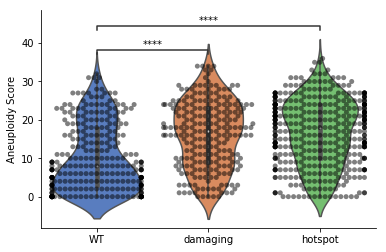

In [26]:
##########################################################################################
######################################### figex 2b #######################################
##########################################################################################

damaging_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='damaging_mutation')
depmap_19Q4_mutation_calls = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='depmap_19Q4_mutation_calls')
hotspot_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='hotspot_mutation')
other_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='other_mutation')




damaging_mutation.columns = damaging_mutation.columns.str.split(' ').str[0]
hotspot_mutation.columns = hotspot_mutation.columns.str.split(' ').str[0]
other_mutation.columns = other_mutation.columns.str.split(' ').str[0]

dam_tp53 = pd.Series('damaging',index=damaging_mutation.loc[:,'TP53'][damaging_mutation.loc[:,'TP53']==1].index)

hot_tp53 = pd.Series('hotspot',index=hotspot_mutation.loc[:,'TP53'][hotspot_mutation.loc[:,'TP53']==1].index)

other_tp53 = pd.Series('other',index=other_mutation.loc[:,'TP53'][other_mutation.loc[:,'TP53']==1].index)




all_lines = set(damaging_mutation.index) | set(hotspot_mutation.index) | set(other_mutation.index)
all_columns = set(damaging_mutation.columns) | set(hotspot_mutation.columns) | set(other_mutation.columns)

other_tp53 = other_tp53.loc[set(other_tp53.index) - set(dam_tp53.index) - set(hot_tp53.index)]
hot_tp53 = hot_tp53.loc[set(hot_tp53.index) - set(dam_tp53.index)]

set(other_tp53.index) - set(dam_tp53.index) - set(hot_tp53.index)

tp53_mutations = pd.concat([pd.concat([dam_tp53,hot_tp53]),other_tp53])

wt_tp53 = pd.Series('WT',index = set(all_lines) - set(tp53_mutations.index))

all_tp53 = pd.concat([tp53_mutations,wt_tp53])


all_tp53 = pd.concat([tp53_mutations,wt_tp53])
all_tp53 = pd.DataFrame(all_tp53,columns=['status'])

all_tp53['Aneuploidy Score'] = anot.loc[all_tp53.index,'num_arm_events']

ax = sns.violinplot(x="status", y="Aneuploidy Score",
                     data=all_tp53 ,palette="muted",order=['WT','damaging','hotspot'])

sns.swarmplot(x="status", y="Aneuploidy Score",
                     data=all_tp53,order=['WT','damaging','hotspot'], color='black',alpha=.5,)



add_stat_annotation(ax, data=all_tp53, x="status", y="Aneuploidy Score", order=['WT','damaging','hotspot'],
                    box_pairs=[('WT', 'damaging'),('WT', 'hotspot')],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2);


plt.xlabel('')
plotting.simpleaxis()

# plt.savefig('updated_tp53.pdf')

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=3.356e-195 stat=-3.866e+01
1 v.s. 2: t-test independent samples, P_val=1.926e-14 stat=-7.883e+00
0 v.s. 2: t-test independent samples, P_val=3.943e-103 stat=-2.704e+01


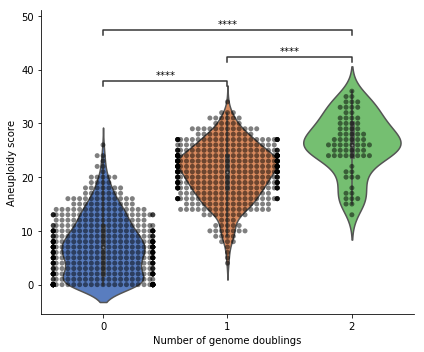

In [28]:
##########################################################################################
######################################### figex 2c #######################################
##########################################################################################



CCLE_ABSOLUTE_combined_table = tc.get(name='ccle-absolute-cn', version=5, file='CCLE_ABSOLUTE_combined_table')

CCLE_ABSOLUTE_combined_table.index = CCLE_ABSOLUTE_combined_table.loc[:,'CCLE_ID']

zero_dups = CCLE_ABSOLUTE_combined_table[CCLE_ABSOLUTE_combined_table.loc[:,'Genome doublings'] == 0].index
dups = CCLE_ABSOLUTE_combined_table.loc[:,'Genome doublings']

anot_dups = pd.DataFrame(anot_CCLE.loc[:,'num_arm_events'].copy())

anot_dups['dubs'] = 0
anot_dups.loc[:,'dubs'] = dups.loc[anot_dups.index]


from statannot import add_stat_annotation

anot_dups.loc[:,'dubs']= anot_dups.loc[:,'dubs'].astype(str)



anot_dups.sort_values('dubs')

plt.subplots(figsize=(6,5))

ax = sns.violinplot(x="dubs", y="num_arm_events",
                     data=anot_dups ,palette="muted",order=['0','1','2'])
ax = sns.swarmplot(x="dubs", y="num_arm_events",
                     data=anot_dups, color='black',alpha=.5,order=['0','1','2'])


add_stat_annotation(ax, data=anot_dups, x="dubs", y="num_arm_events", order=['0','1','2'],
                    box_pairs=[('0', '1'), ('1', '2'), ('0', '2')],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2);


plt.ylabel('Aneuploidy score')
plt.xlabel('Number of genome doublings')
plotting.simpleaxis(ax)
plt.tight_layout()
#plt.savefig('supp1/WGD_2.pdf')

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

Text(36.625,0.5,'het70 score')

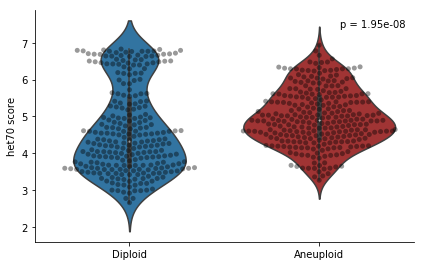

In [42]:
##########################################################################################
######################################### figex 2d #######################################
##########################################################################################

from scipy import stats

sample_info_depmap = sample_info.copy()
sample_info_depmap.index = sample_info.loc[:,'DepMap_ID']#.loc[gene_effect_rnai_achilles.index,'lineage']

public_19Q4_proteincoding_tpm = tc.get(name='depmap-rnaseq-expression-data-ccd0', version=16, file='public_19Q4_proteincoding_tpm')

public_19Q4_proteincoding_tpm.columns = public_19Q4_proteincoding_tpm.columns.str.split(' ').str[0]

cin70 = pd.read_csv('cin70genes.csv',index_col=0,header=None)
het70 = pd.read_csv('het70genes.csv')

big_list_cin70 = []


het70_genes = het70.drop([0]).values[:,0]



# now create our signature scores

cin70_scores = public_19Q4_proteincoding_tpm.loc[:,list_cin70].mean(axis=1)
het70_scores = public_19Q4_proteincoding_tpm.loc[:,het70_genes].mean(axis=1)

public_19Q4_proteincoding_tpm_CCLE = public_19Q4_proteincoding_tpm.copy()

public_19Q4_proteincoding_tpm_CCLE.index = sample_info_depmap.loc[public_19Q4_proteincoding_tpm_CCLE.index,'CCLE_Name']

cin70_scores_CCLE = public_19Q4_proteincoding_tpm_CCLE.loc[:,list_cin70].mean(axis=1)
het70_scores_CCLE = public_19Q4_proteincoding_tpm_CCLE.loc[:,het70_genes].mean(axis=1)



scores = pd.DataFrame(cin70_scores_CCLE.copy())
scores.loc[:,'het70'] = het70_scores_CCLE.loc[scores.index]
scores.columns = ['cin70','het70']
scores = pd.melt(scores.reset_index(), id_vars='CCLE_Name')
scores.index = scores.loc[:,'CCLE_Name']
scores = scores.dropna()

scores['num_arm_events'] = 0
scores.loc[:,'num_arm_events'] = anot_CCLE.loc[scores.index,'num_arm_events']


shared = set(anot.loc[:,'CCLE_ID']) & set(scores.index)
temp = scores.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'


temp2 = temp[temp.loc[:,'variable'] == 'het70']

ax = sns.violinplot(x="ploidy", y="value",
                     data=temp2, palette = my_pal,order=my_order)
ax = sns.swarmplot(x="ploidy", y="value",
                     data=temp2, color='black',alpha=.4,order=my_order)
plotting.simpleaxis(ax)

tt,p_val = stats.ttest_ind(temp2.loc[trus,'value'].dropna(),temp2.loc[falsee,'value'].dropna())
ax.legend(title='p = '+ str(round(p_val,10)),frameon=False)
plt.tight_layout()
plt.xlabel('')
plt.ylabel('het70 score')

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
No handles with labels found to put in legend.


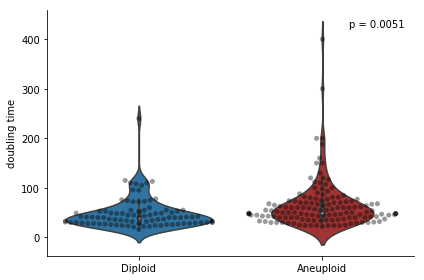

In [37]:
##########################################################################################
######################################### figex 2e #######################################
##########################################################################################

pd.DataFrame(anot_CCLE.loc[:,'num_arm_events'].copy())


shared = set(anot.loc[:,'CCLE_ID']) 
temp = pd.DataFrame(anot_CCLE.loc[:,'num_arm_events'].copy())
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

temp['dub'] = 0

temp['dub'] = anot_CCLE.loc[temp.index,'RNAi_doubling_time']

temp_doubling = temp[temp.loc[:,'dub']== temp.loc[:,'dub']]





ax = sns.violinplot(y="dub", x="ploidy",
                     data=temp_doubling.dropna(), palette = my_pal,order=my_order)


ax = sns.swarmplot(y="dub", x="ploidy",
                     data=temp_doubling.dropna(),color='black',alpha=.4,order=my_order)
tt,p_val = stats.ttest_ind(temp_doubling.loc[trus,'dub'].dropna(),temp_doubling.loc[falsee,'dub'].dropna())
ax.legend(title='p = '+ str(round(p_val,4)),frameon=False)

plt.ylabel('doubling time')
plt.xlabel('')

plt.tight_layout()
plotting.simpleaxis(ax)

# plt.savefig('supp1/doubling_5.pdf')
